In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import joblib

In [2]:
# Load training input and target data
train_input = pd.read_csv(r'Train_60\X_Train_Data_Input.csv')
train_target = pd.read_csv(r'Train_60\Y_Train_Data_Target.csv')

# Load test input and target data
test_input = pd.read_csv(r'Test_20\X_Test_Data_Input.csv')
test_target = pd.read_csv(r'Test_20\Y_Test_Data_Target.csv')

### concate the data and drop the id column

In [3]:
train_data = pd.concat([train_input, train_target["target"]], axis=1)
test_data = pd.concat([test_input, test_target["target"]], axis=1)

In [4]:
train_data = train_data.drop('ID', axis=1)
test_data = test_data.drop('ID', axis=1)

**we will be creating a dict to store the data that needs to be saved**

In [5]:
imp_info_dict = {}

### check and handle null values 

In [6]:
print("testing null values for train dataset")
# Check for missing values in train data
print(train_data.isnull().sum())

print("\n**************************************************************\n")
print("testing null values for test dataset")
# Check for missing values in test data
print(test_data.isnull().sum())

testing null values for train dataset
Column0          9
Column1          0
Column2          0
Column3     126303
Column4     127710
Column5     167180
Column6       3850
Column7          0
Column8       3850
Column9     732137
Column10         0
Column11         0
Column12         0
Column13         0
Column14    365703
Column15     16456
Column16         0
Column17         0
Column18         0
Column19         0
Column20         0
Column21         0
target           0
dtype: int64

**************************************************************

testing null values for test dataset
Column0          2
Column1          0
Column2          0
Column3      42234
Column4      42710
Column5      55659
Column6       1234
Column7          0
Column8       1234
Column9     243853
Column10         0
Column11         0
Column12         0
Column13         0
Column14    121679
Column15      5485
Column16         0
Column17         0
Column18         0
Column19         0
Column20         0
Column21   

In [7]:
# Get the total number of missing values in each column
null_counts = train_data.isnull().sum()

# Get the percentage of missing values in each column
null_percentage = (train_data.isnull().sum() / train_data.shape[0]) * 100

In [8]:
null_data = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage': null_percentage
})

In [9]:
# Get the total number of missing values in each column for test data
test_null_counts = test_data.isnull().sum()

# Get the percentage of missing values in each column for test data
test_null_percentage = (test_data.isnull().sum() / test_data.shape[0]) * 100

# Create a DataFrame to view the null count and percentage for the test set
test_null_data = pd.DataFrame({
    'Null Count': test_null_counts,
    'Null Percentage': test_null_percentage
})

we will handle the null values and save the columns that needs to be droped

In [10]:
def handle_missing_values(train_data, test_data, null_data = null_data,test_null_data = test_null_data):
    
    # Get columns to drop from training data with 20% as threshold
    train_columns_to_drop = null_data[null_data['Null Percentage'] > 20].index

    # Get columns to drop from test data
    test_columns_to_drop = test_null_data[test_null_data['Null Percentage'] > 20].index

    # Get the union of columns to drop from both train and test data
    columns_to_drop_union = set(train_columns_to_drop).union(set(test_columns_to_drop))

    # Drop the columns from both datasets
    train_data_temp = train_data.drop(columns_to_drop_union, axis=1)
    test_data_temp = test_data.drop(columns_to_drop_union, axis=1)

    # Fill missing values in  columns using the median from the training data
    train_data_temp = train_data_temp.fillna(train_data_temp.median())
    test_data_temp = test_data_temp.fillna(test_data_temp.median())
    
    return train_data_temp,test_data_temp,columns_to_drop_union

In [11]:
train_data,test_data,colums_to_drop = handle_missing_values(train_data,test_data)

save the columns to drop for later use

In [12]:
imp_info_dict["colums_to_drop"] = colums_to_drop

In [13]:
import json

In [18]:
colums_to_drop = list(colums_to_drop)

In [19]:
with open('colums_to_drop_list.json', 'w') as json_file:
    json.dump(colums_to_drop, json_file)

### Preprocessing the data

In [13]:
def preprocess_train_data(train_data):
    
    #1 drop duplicates from train data
    train_data = train_data.drop_duplicates().reset_index(drop=True)
    
    #2 handle outliers
    indep_cols = train_data.columns.difference(['target'])
    z_scores = np.abs(stats.zscore(train_data[indep_cols]))
    # Create a boolean mask where all Z-scores are below the threshold we have set it to 4
    outlier_mask = (z_scores < 4 ).all(axis=1)
    # Apply the mask to the entire dataset and reset the index
    train_data_clean = train_data[outlier_mask].reset_index(drop=True)
    
    return train_data_clean

In [14]:
train_data = preprocess_train_data(train_data)

**normalization/scaling**

we also need to save the applied scaling for future use

In [15]:
def apply_scaling(train_data,test_data):
    
    train_target = train_data['target']
    test_target = test_data['target']
    train_features = train_data.drop(columns=['target'])
    test_features = test_data.drop(columns=['target'])
    
    scaler = StandardScaler()
    
    # Fit the scaler on training data, we will use it to transform the test data as well
    scaler.fit(train_features)
    
    #saving the scaler for future use
    joblib.dump(scaler, 'scaler.pkl')
    
    # Transform both training and testing data
    train_features_scaled = pd.DataFrame(scaler.transform(train_features), columns=train_features.columns)
    test_features_scaled = pd.DataFrame(scaler.transform(test_features), columns=test_features.columns)
    
    # Add the target column back
    train_data_scaled = train_features_scaled.copy()
    train_data_scaled['target'] = train_target.reset_index(drop=True)
    test_data_scaled = test_features_scaled.copy()
    test_data_scaled['target'] = test_target.reset_index(drop=True)
    
    
    return train_data_scaled,test_data_scaled

In [16]:
train_data,test_data = apply_scaling(train_data,test_data)

### Model selection

from my privious attempts i have found 4 models to work best - 
RandomForest,GradientBoosting,AdaBoost,XGBoost

In [17]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    make_scorer, f1_score, accuracy_score, precision_score,
    recall_score, roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\abhij\anaconda3\envs\gstn_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
X_train = train_data.drop(columns=['target'])
y_train = train_data['target']

In [19]:
X_test = test_data.drop(columns=['target'])
y_test = test_data['target']

**adding crossval for optuna**

we will be judging based on the f1 score

In [20]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define F1 scorer
f1_scorer = make_scorer(f1_score)

### RandomForestClassifier

In [21]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    return -np.mean(scores)


In [22]:
study_rf = optuna.create_study(direction='minimize', study_name='RandomForest')
study_rf.optimize(objective_rf, n_trials=10)

[I 2024-10-12 08:30:08,998] A new study created in memory with name: RandomForest
[I 2024-10-12 08:30:33,355] Trial 0 finished with value: -0.7771643038822611 and parameters: {'n_estimators': 150, 'max_depth': 5, 'class_weight': None}. Best is trial 0 with value: -0.7771643038822611.
[I 2024-10-12 08:30:52,977] Trial 1 finished with value: -0.8729300566978652 and parameters: {'n_estimators': 100, 'max_depth': 15, 'class_weight': None}. Best is trial 1 with value: -0.8729300566978652.
[I 2024-10-12 08:32:05,331] Trial 2 finished with value: -0.8708296750140258 and parameters: {'n_estimators': 400, 'max_depth': 11, 'class_weight': None}. Best is trial 1 with value: -0.8729300566978652.
[I 2024-10-12 08:32:22,936] Trial 3 finished with value: -0.8489109639948462 and parameters: {'n_estimators': 100, 'max_depth': 7, 'class_weight': None}. Best is trial 1 with value: -0.8729300566978652.
[I 2024-10-12 08:33:30,191] Trial 4 finished with value: -0.8545054683817078 and parameters: {'n_estimat

In [23]:
best_params_rf = study_rf.best_params
best_model_rf = RandomForestClassifier(**best_params_rf)
best_model_rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=15)

### GradientBoostingClassifier

In [33]:
def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'random_state': 42
    }
    model = GradientBoostingClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    return -np.mean(scores)


In [34]:
study_gb = optuna.create_study(direction='minimize', study_name='GradientBoosting')
study_gb.optimize(objective_gb, n_trials=5)



[I 2024-10-12 08:57:33,349] A new study created in memory with name: GradientBoosting
[I 2024-10-12 08:58:41,218] Trial 0 finished with value: -0.8725243311959555 and parameters: {'n_estimators': 100, 'max_depth': 5}. Best is trial 0 with value: -0.8725243311959555.
[I 2024-10-12 09:03:03,078] Trial 1 finished with value: -0.873205370193776 and parameters: {'n_estimators': 300, 'max_depth': 5}. Best is trial 1 with value: -0.873205370193776.
[I 2024-10-12 09:11:40,098] Trial 2 finished with value: -0.8727093020060593 and parameters: {'n_estimators': 450, 'max_depth': 7}. Best is trial 1 with value: -0.873205370193776.
[I 2024-10-12 09:16:03,839] Trial 3 finished with value: -0.8717650488370584 and parameters: {'n_estimators': 200, 'max_depth': 9}. Best is trial 1 with value: -0.873205370193776.
[I 2024-10-12 09:18:17,148] Trial 4 finished with value: -0.8735430257013256 and parameters: {'n_estimators': 150, 'max_depth': 6}. Best is trial 4 with value: -0.8735430257013256.


In [35]:
best_params_gb = study_gb.best_params
best_model_gb = GradientBoostingClassifier(**best_params_gb)
best_model_gb.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=6, n_estimators=150)

### AdaBoostClassifier

In [36]:
def objective_ada(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
        'random_state': 42
    }
    model = AdaBoostClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    return -np.mean(scores)


In [37]:
study_ada = optuna.create_study(direction='minimize', study_name='AdaBoost')
study_ada.optimize(objective_ada, n_trials=10)


[I 2024-10-12 09:21:48,381] A new study created in memory with name: AdaBoost
[I 2024-10-12 09:23:13,042] Trial 0 finished with value: -0.8634650743819554 and parameters: {'n_estimators': 250}. Best is trial 0 with value: -0.8634650743819554.
[I 2024-10-12 09:24:38,344] Trial 1 finished with value: -0.8634650743819554 and parameters: {'n_estimators': 250}. Best is trial 0 with value: -0.8634650743819554.
[I 2024-10-12 09:25:29,570] Trial 2 finished with value: -0.862866614476566 and parameters: {'n_estimators': 150}. Best is trial 0 with value: -0.8634650743819554.
[I 2024-10-12 09:26:21,286] Trial 3 finished with value: -0.862866614476566 and parameters: {'n_estimators': 150}. Best is trial 0 with value: -0.8634650743819554.
[I 2024-10-12 09:27:29,857] Trial 4 finished with value: -0.8630851185458034 and parameters: {'n_estimators': 200}. Best is trial 0 with value: -0.8634650743819554.
[I 2024-10-12 09:30:17,698] Trial 5 finished with value: -0.8635327068710215 and parameters: {'n_es

In [38]:
best_params_ada = study_ada.best_params
best_model_ada = AdaBoostClassifier(**best_params_ada)
best_model_ada.fit(X_train, y_train)


c:\Users\abhij\anaconda3\envs\gstn_env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=500)

### XGBClassifier

In [51]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'n_jobs': -1
    }
    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    return -np.mean(scores)


In [52]:
study_xgb = optuna.create_study(direction='minimize', study_name='XGBoost')
study_xgb.optimize(objective_xgb, n_trials=50)



[I 2024-10-12 09:52:02,167] A new study created in memory with name: XGBoost
[I 2024-10-12 09:52:06,320] Trial 0 finished with value: -0.8744665975995196 and parameters: {'n_estimators': 150, 'learning_rate': 0.019905389039643735, 'max_depth': 8}. Best is trial 0 with value: -0.8744665975995196.
[I 2024-10-12 09:52:36,320] Trial 1 finished with value: -0.8589469829918409 and parameters: {'n_estimators': 400, 'learning_rate': 0.16939334386088584, 'max_depth': 19}. Best is trial 0 with value: -0.8744665975995196.
[I 2024-10-12 09:53:08,241] Trial 2 finished with value: -0.8603184078780711 and parameters: {'n_estimators': 500, 'learning_rate': 0.16139264148451216, 'max_depth': 16}. Best is trial 0 with value: -0.8744665975995196.
[I 2024-10-12 09:53:13,779] Trial 3 finished with value: -0.8735193431939754 and parameters: {'n_estimators': 150, 'learning_rate': 0.1120573508990784, 'max_depth': 11}. Best is trial 0 with value: -0.8744665975995196.
[I 2024-10-12 09:53:33,442] Trial 4 finished

In [49]:
best_params_xgb = study_xgb.best_params
best_model_xgb = XGBClassifier(**best_params_xgb)
best_model_xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09148434270415107,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Evaluate models

In [61]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        # For models without predict_proba
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

**Evaluate RandomForestClassifier**


Model: RandomForest
Accuracy: 0.9774
Precision: 0.8395
Recall: 0.9400
F1 Score: 0.8869
AUC-ROC: 0.9943
Confusion Matrix:
[[232598   4436]
 [  1481  23197]]


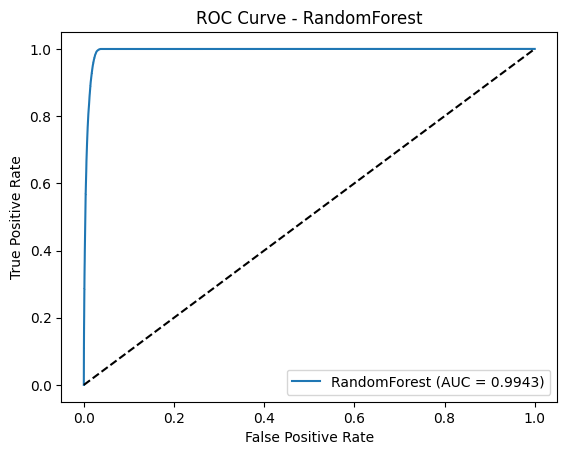

In [43]:
evaluate_model(best_model_rf, X_test, y_test, 'RandomForest')

**Evaluate GradientBoostingClassifier**


Model: GradientBoosting
Accuracy: 0.9773
Precision: 0.8384
Recall: 0.9402
F1 Score: 0.8864
AUC-ROC: 0.9942
Confusion Matrix:
[[232563   4471]
 [  1476  23202]]


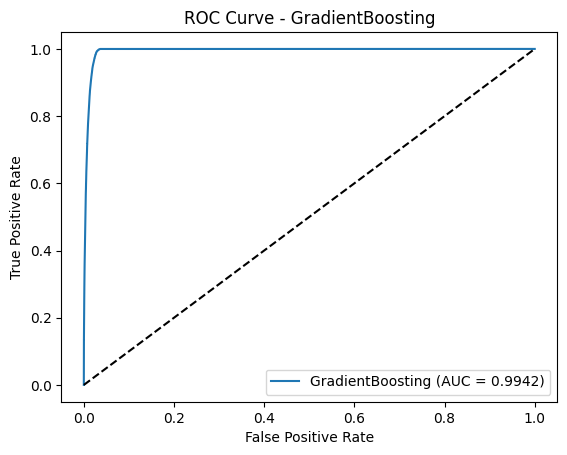

In [44]:
evaluate_model(best_model_gb, X_test, y_test, 'GradientBoosting')

**Evaluate AdaBoostClassifier**


Model: AdaBoost
Accuracy: 0.9751
Precision: 0.8266
Recall: 0.9314
F1 Score: 0.8759
AUC-ROC: 0.9931
Confusion Matrix:
[[232211   4823]
 [  1692  22986]]


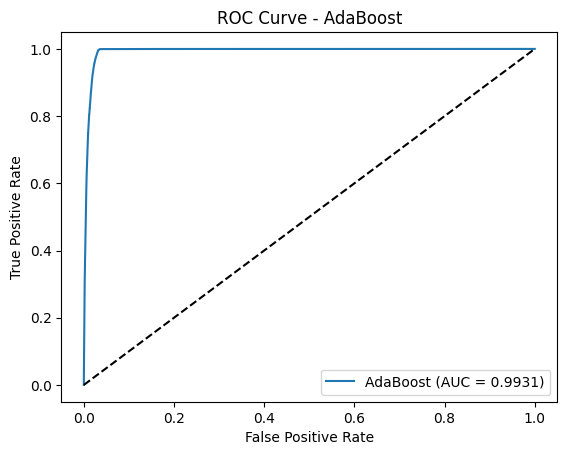

In [45]:
evaluate_model(best_model_ada, X_test, y_test, 'AdaBoost')


** Evaluate XGBClassifier**

In [1]:
evaluate_model(best_model_xgb, X_test, y_test, 'XGBoost')

NameError: name 'evaluate_model' is not defined

### saving the best model 

In [60]:
import joblib
joblib.dump(best_model_xgb, 'best_model.pkl')

['best_model.pkl']